In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statannotations.Annotator import Annotator
from glob import glob
import pickle
from collections import defaultdict
import scipy.stats
import re
from tqdm import tqdm

In [2]:
motif_len = 5

In [3]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/motif_predictions/'

In [4]:
consv_df = pd.read_csv(data_dir + f'species_aware/conservation_k{motif_len}_new.csv.gz')

In [5]:
test_df = pd.read_csv(data_dir + 'split_75_25/test.csv').set_index('seq_name').squeeze() #compute conservation scores only on fraction of data

In [6]:
table_motifs = pd.read_excel(data_dir + '../dominguez_2018/1-s2.0-S1097276518303514-mmc4.xlsx',
             sheet_name = motif_len-4, skiprows=1)

selected_motifs = []

for col_idx in range(0,len(table_motifs.columns),2):
    motif = table_motifs.iloc[:,col_idx:col_idx+1]
    stepwise_r = table_motifs.iloc[:,col_idx+1:col_idx+2]
    selected_motifs.extend(motif[(stepwise_r>0.1).values].values.tolist())

selected_motifs = np.unique(np.array(selected_motifs).flatten())
#
#motif_preds = motif_preds[motif_preds.motif.isin(selected_motifs)]

In [14]:
df = consv_df[(consv_df.motif.isin(selected_motifs))&(consv_df.is_eCLIP)]

av_mobility = {}
for Nmatches in (0,10,50,100,250,500,1000,2500,5000):
    av_mobility[Nmatches] = (df[f'Nmatches_{Nmatches}']-df.Nmatches_0).mean()

Text(0, 0.5, 'average mobility')

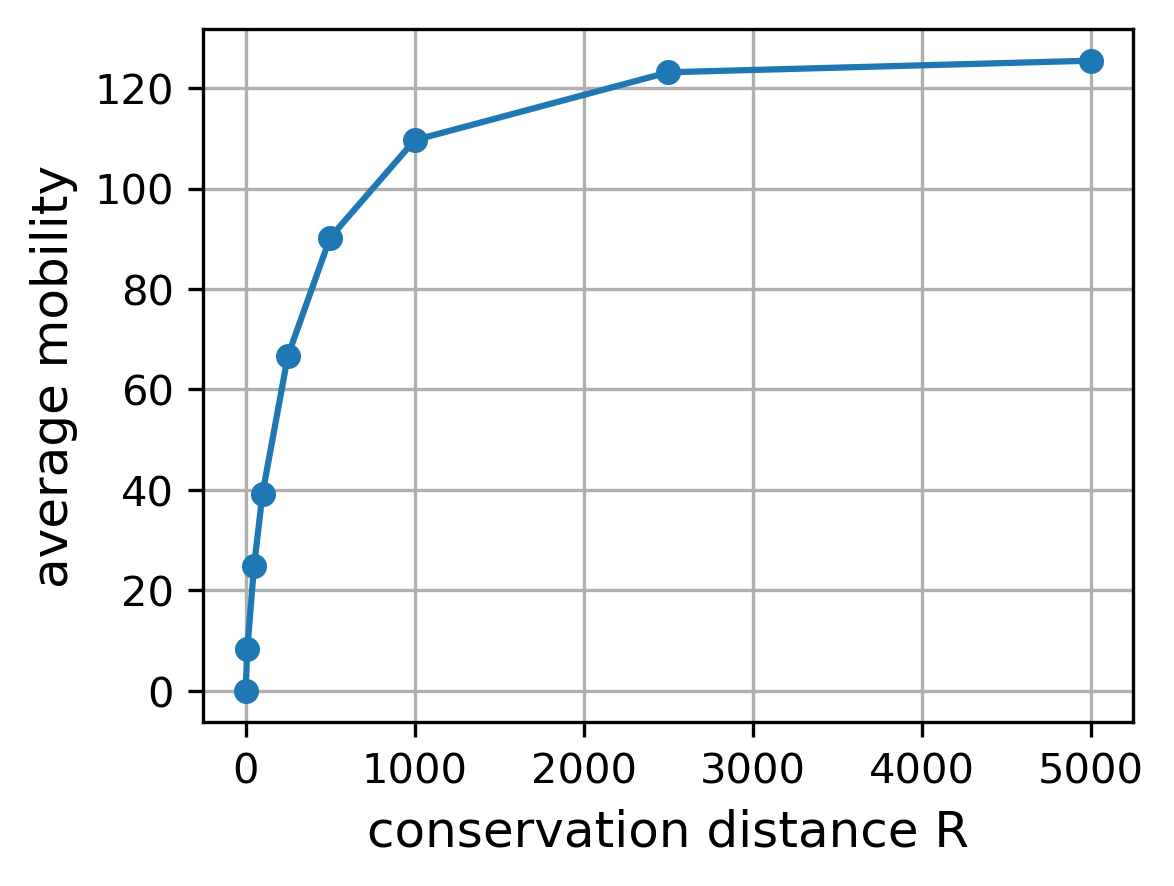

In [15]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)

ax.plot(av_mobility.keys(), av_mobility.values(), marker='o', markersize=5)
ax.grid(True)
ax.set_xlabel('conservation distance R', fontsize=12)
ax.set_ylabel('average mobility', fontsize=12)

In [7]:
with open(data_dir + 'species_aware/probas.pickle','rb') as f:
    probs = dict(pickle.load(f)) 

In [8]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [9]:
motif_preds = []

for seq_name,seq in tqdm(test_df.items(), total=len(test_df)):
    for motif_start in range(0,len(seq)-motif_len):
        motif_end = motif_start+motif_len
        motif = seq[motif_start:motif_end]
        motif_mapping = [list(range(len(motif))),list(map(lambda x:mapping[x],motif))]
        avg_target_prob = np.mean(probs[seq_name][motif_start:motif_end][motif_mapping[0], motif_mapping[1]])
        motif_preds.append((seq_name,motif_start,motif,avg_target_prob))
            
motif_preds = pd.DataFrame(motif_preds,columns = ['seq_name','motif_start','motif','avg_target_prob'])

100%|██████████| 4534/4534 [01:41<00:00, 44.70it/s]


In [10]:
motif_preds = motif_preds.merge(consv_df, how='left')

In [11]:
N_species = 241

In [12]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib

pal = sns.color_palette('mako')

mako = LinearSegmentedColormap.from_list('',pal.as_hex()) #mako

matplotlib.rcParams.update({'font.size': 14})

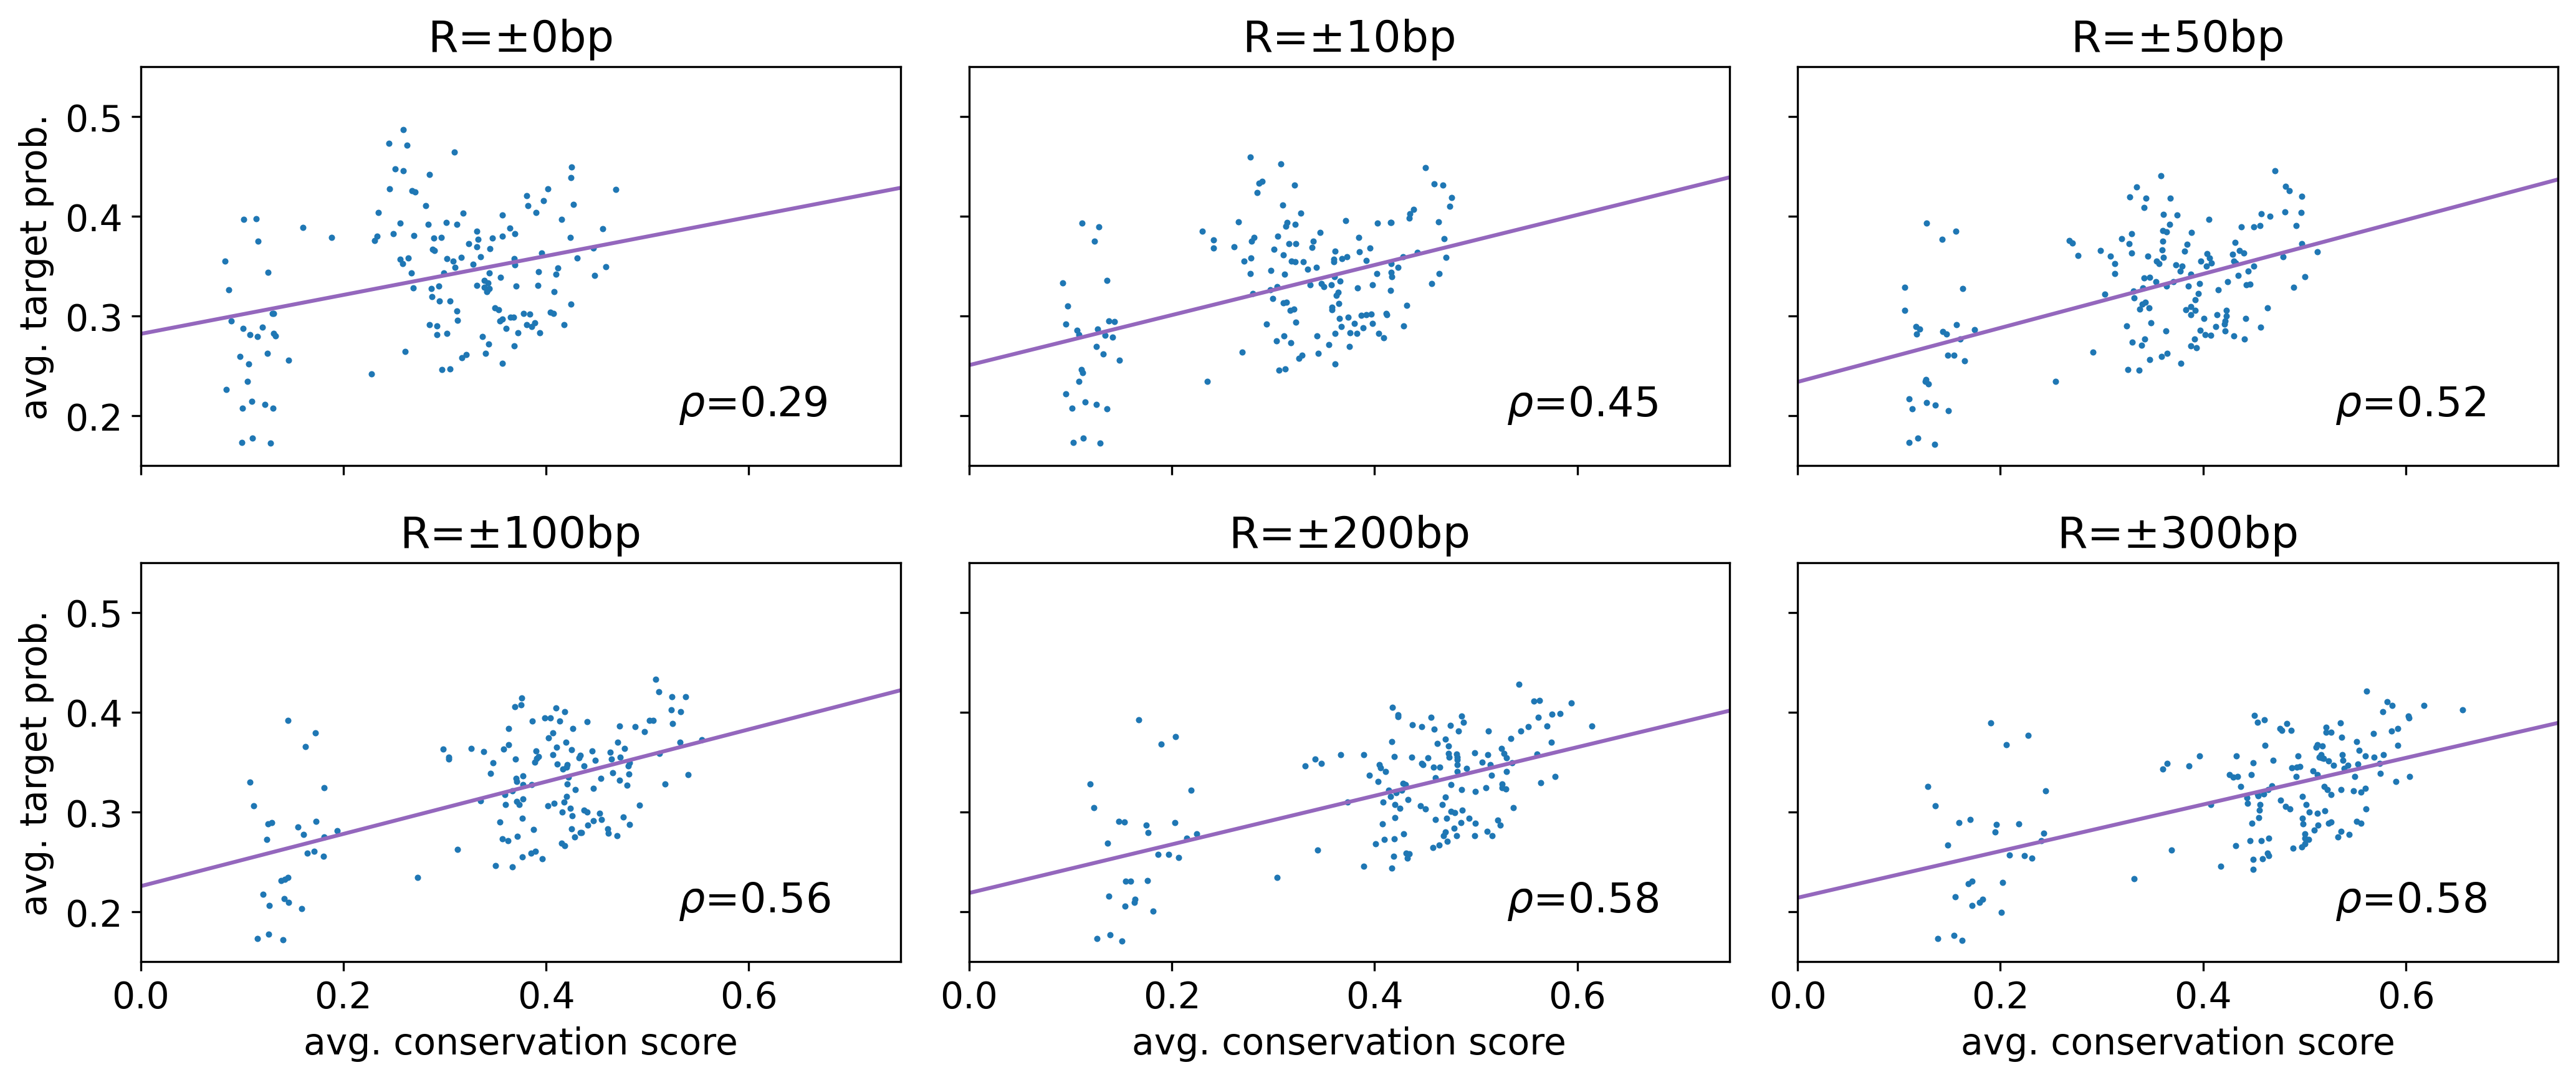

In [14]:
fig, axes = plt.subplots(2,3, figsize=(14,6), dpi=300)

axes = axes.flatten()

for tol,ax_idx in zip((0,10,50,100,200,300),range(6)): 

    ax = axes[ax_idx]
    
    consv_score_column = f'Nmatches_{tol}'

    consv_score_vs_prob = motif_preds[(motif_preds.L_nearest>2*tol)&(motif_preds.motif.isin(selected_motifs))&(motif_preds.is_eCLIP)].groupby('motif')[['avg_target_prob',  consv_score_column]].mean()
    
    x = consv_score_vs_prob[consv_score_column]/N_species
    y = consv_score_vs_prob.avg_target_prob
    
    #scatter = ax.scatter(x,y, s=2, c = consv_score_vs_prob.motif_entropy, cmap=mako)
    
    #color = ['tab:red' if x in top_motifs.values else 'tab:blue' for x in consv_score_vs_prob.index]
    
    scatter = ax.scatter(x,y, s=2)
    
    pearson_r, p_value = scipy.stats.pearsonr(x,y)
        
    k, b = np.polyfit(x,y,deg=1)
    
    
    ax.plot(np.linspace(0.0,0.75), k*np.linspace(0.0,0.75)+b, c='tab:purple')
    
    ax.text(x=0.53, y=0.2, s=r"$\rho$"+f'={pearson_r:.2f}', fontsize=16)
    
    ax.set_xlim([0,0.75])
    ax.set_ylim([0.15,0.55])
    
    if ax_idx!=0 and ax_idx!=3:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('avg. target prob.')

    if ax_idx<3:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('avg. conservation score')
        
    #if ax_idx in (2,5):
    #    divider = make_axes_locatable(ax)
    #    cax = divider.append_axes('right', size='5%', pad=0.05)
    #    cbar = fig.colorbar(scatter, cax=cax, orientation='vertical',label='motif entropy');
        
    ax.set_title(f'R=±{tol}bp')
        
fig.tight_layout()